In [22]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
encoder = LabelEncoder()
prod_df=pd.read_csv('updated2.csv')
prod_df=prod_df.drop(['date'], axis='columns')
prod_df["team1"] = encoder.fit_transform(prod_df["team1"])
prod_df["team2"] = encoder.transform(prod_df["team2"])

prod_df.head()

,team1,team2,Winner,team1Home,team2Home,neutralVenue,friendly,qualifier,finaltourn,team1_win_rate_10,...,team2_win_rate_40,team2_loss_rate_40,team2_draw_rate_40,team2_goal_diff_avg_40,team2_confed_form_40,team2_win_rate_50,team2_loss_rate_50,team2_draw_rate_50,team2_goal_diff_avg_50,team2_confed_form_50
0,67,92,2.0,1,0,0,0,1,0,0.6,...,0.475000,0.175000,0.350000,-0.575000,0.625000,0.531915,0.170213,0.297872,-0.744681,0.625000
1,78,94,0.0,0,0,1,0,0,1,0.8,...,0.909091,0.000000,0.090909,-3.727273,0.909091,0.909091,0.000000,0.090909,-3.727273,0.909091
2,72,177,1.0,0,0,1,0,1,0,0.6,...,0.607143,0.214286,0.178571,-0.892857,0.560000,0.607143,0.214286,0.178571,-0.892857,0.560000
3,139,91,0.0,1,0,0,0,1,0,0.4,...,0.675000,0.125000,0.200000,-1.225000,0.675000,0.700000,0.100000,0.200000,-1.200000,0.700000
4,38,86,1.0,0,0,1,0,0,1,0.7,...,0.700000,0.075000,0.225000,-1.700000,0.700000,0.688889,0.066667,0.244444,-1.644444,0.707317


In [23]:
from sklearn.model_selection import train_test_split

X = prod_df.drop(columns=["Winner"]) 
y = prod_df["Winner"] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [24]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
param_grid = {
    "max_depth": [3, 5, 7, 10],  
    "learning_rate": [0.01, 0.05, 0.1, 0.2],  
    "n_estimators": [100, 300, 500, 800],  
    "subsample": [0.7, 0.8, 1.0],  
    "colsample_bytree": [0.7, 0.8, 1.0],  
    "reg_lambda": [1, 5, 10],  # L2 Regularization  
    "reg_alpha": [0, 1, 5]  # L1 Regularization  
}

xgb = XGBClassifier(objective="multi:softprob", eval_metric="mlogloss")

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=20, 
    cv=5, 
    scoring="accuracy",
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
print("Best Parameters:", best_params)
best_xgb = XGBClassifier(**best_params, objective="multi:softprob", eval_metric="mlogloss")
best_xgb.fit(X_train, y_train)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'subsample': 0.8, 'reg_lambda': 10, 'reg_alpha': 0, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.7}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [25]:
accuracy = best_xgb.score(X_test, y_test)
print(f"Test Accuracy After Tuning: {accuracy:.4f}")

Test Accuracy After Tuning: 0.7480


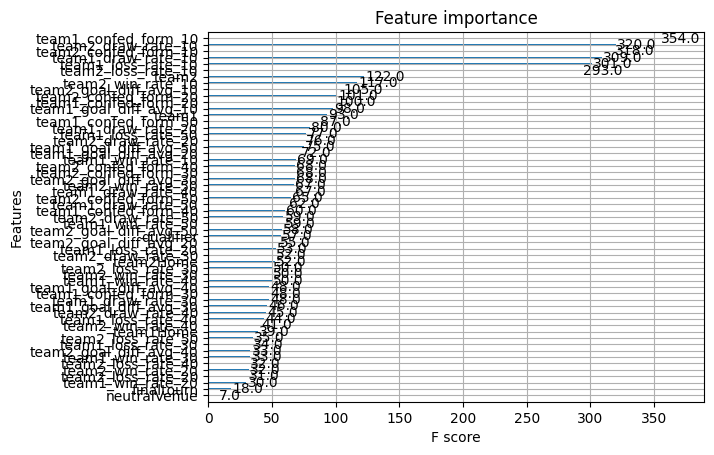

In [26]:
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(best_xgb)
plt.show()

In [27]:
best_xgb.save_model("best_xgb.json")


In [28]:
import joblib
joblib.dump(encoder, "encoder.joblib")

['encoder.joblib']